In [15]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

from xgboost import XGBClassifier

import matplotlib.pyplot as plt

In [16]:
#função para automatizar as métricas
def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):

    print("\nMétricas de avaliação de treino:")
    y_pred_train = estimator.predict(X_train)
    cm_train = confusion_matrix(y_train, y_pred_train)
    ConfusionMatrixDisplay(cm_train).plot(cmap='viridis')
    plt.show()
    print(classification_report(y_train, y_pred_train))
    auc_roc = roc_auc_score(y_train, y_pred_train)
    print("AuC:", auc_roc)

    print("\nMétricas de avaliação de teste:")
    y_pred_test = estimator.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test)
    ConfusionMatrixDisplay(cm_test).plot(cmap='viridis')
    plt.show()
    print(classification_report(y_test, y_pred_test))
    auc_roc = roc_auc_score(y_test, y_pred_test)
    print("AuC:", auc_roc)

CSV

In [17]:
#carregamento dos dados
df = pd.read_csv('train_treated.csv')

#seleção de uma amostra devido o custo necessário para o conjunto completo
df = df.sample(5000)

#definição das features e target
X = df.drop(columns="credit_score")
y = df["credit_score"]

#divisião dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
##pré-processamento dos dados de treino
#features numéricas
features_numerics = X_train.select_dtypes(include=np.number).columns.tolist()

num_imputer = SimpleImputer(strategy="median")
X_train[features_numerics] = num_imputer.fit_transform(X_train[features_numerics])

scaler = StandardScaler()
X_train[features_numerics] = scaler.fit_transform(X_train[features_numerics])

#features categóricas
features_categorics = X_train.select_dtypes(exclude=np.number).columns.tolist()
encoder = OneHotEncoder()
X_train_cat_encoded = encoder.fit_transform(X_train[features_categorics])

#combinação das features numéricas e categóricas pós-transformação
X_train_preprocessed = np.hstack((X_train[features_numerics], X_train_cat_encoded.toarray()))

In [19]:
#pré-processamento dos dados de teste
X_test[features_numerics] = num_imputer.transform(X_test[features_numerics])
X_test[features_numerics] = scaler.transform(X_test[features_numerics])
X_test_cat_encoded = encoder.transform(X_test[features_categorics])

#combinação das features numéricas e categóricas pós-transformação
X_test_preprocessed = np.hstack((X_test[features_numerics], X_test_cat_encoded.toarray()))


Métricas de avaliação de treino:


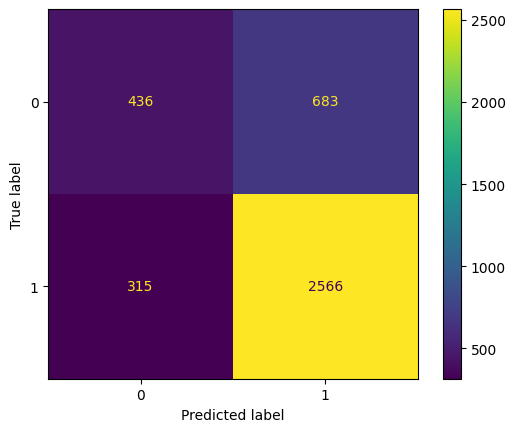

              precision    recall  f1-score   support

           0       0.58      0.39      0.47      1119
           1       0.79      0.89      0.84      2881

    accuracy                           0.75      4000
   macro avg       0.69      0.64      0.65      4000
weighted avg       0.73      0.75      0.73      4000

AuC: 0.6401482828391865

Métricas de avaliação de teste:


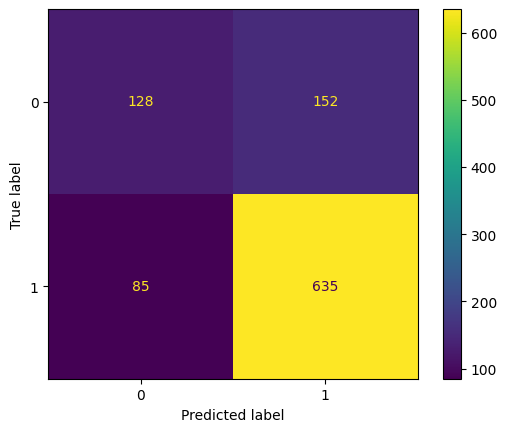

              precision    recall  f1-score   support

           0       0.60      0.46      0.52       280
           1       0.81      0.88      0.84       720

    accuracy                           0.76      1000
   macro avg       0.70      0.67      0.68      1000
weighted avg       0.75      0.76      0.75      1000

AuC: 0.6695436507936507


In [20]:
#treinando o modelo SVM
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train_preprocessed, y_train)

#avaliação do modelo com as métricas de classificação
metricas_classificacao(svm_model, X_train_preprocessed, X_test_preprocessed, y_train, y_test)

In [21]:
#testando os hiperparâmetros
param_grid_svc = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': np.logspace(-1, 1, 3),
    'gamma': ['scale', 'auto'] + np.logspace(-1, 1, 3).tolist()
}

splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
grid_svc = GridSearchCV(
    estimator = SVC(random_state = 42),
    param_grid = param_grid_svc,
    scoring = 'roc_auc',
    cv = splitter
)

Melhores hiperparâmetros: {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}

Métricas de avaliação de treino:


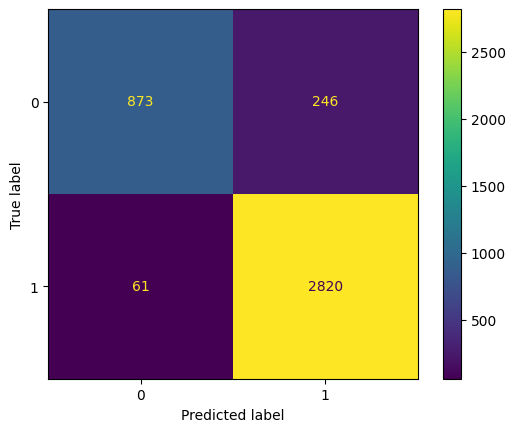

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1119
           1       0.92      0.98      0.95      2881

    accuracy                           0.92      4000
   macro avg       0.93      0.88      0.90      4000
weighted avg       0.92      0.92      0.92      4000

AuC: 0.8794938270800743

Métricas de avaliação de teste:


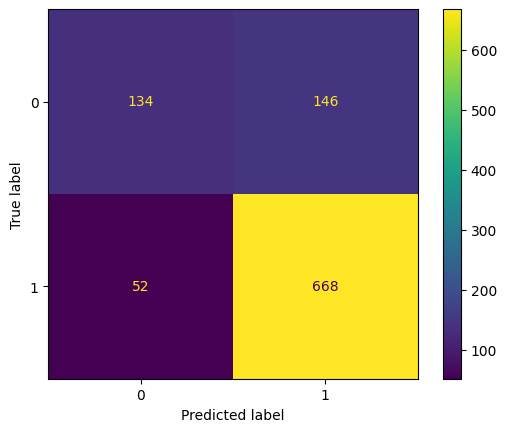

              precision    recall  f1-score   support

           0       0.72      0.48      0.58       280
           1       0.82      0.93      0.87       720

    accuracy                           0.80      1000
   macro avg       0.77      0.70      0.72      1000
weighted avg       0.79      0.80      0.79      1000

AuC: 0.7031746031746031


In [22]:
#treinamento do modelo
grid_svc.fit(X_train_preprocessed, y_train)

#definição do melhor hiperparâmetro
best_params = grid_svc.best_params_
best_model = grid_svc.best_estimator_
svm_model.fit(X_train_preprocessed, y_train)
print('Melhores hiperparâmetros:', best_params)

#avaliação do modelo com os best params
metricas_classificacao(best_model, X_train_preprocessed, X_test_preprocessed, y_train, y_test)

XGBoosting

In [23]:
#carregamento dos dados
df = pd.read_csv('train_treated.csv')

#definição das features e target
X = df.drop(columns="credit_score")
y = df["credit_score"]

#divisião dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [24]:
##pré-processamento dos dados de treino
#features numéricas
features_numerics = X_train.select_dtypes(include=np.number).columns.tolist()

num_imputer = SimpleImputer(strategy="median")
X_train[features_numerics] = num_imputer.fit_transform(X_train[features_numerics])

scaler = StandardScaler()
X_train[features_numerics] = scaler.fit_transform(X_train[features_numerics])

#features categóricas
features_categorics = X_train.select_dtypes(exclude=np.number).columns.tolist()
encoder = OneHotEncoder()
X_train_cat_encoded = encoder.fit_transform(X_train[features_categorics])

#combinação das features numéricas e categóricas pós-transformação
X_train_preprocessed = np.hstack((X_train[features_numerics], X_train_cat_encoded.toarray()))

In [25]:
#pré-processamento dos dados de teste
X_test[features_numerics] = num_imputer.transform(X_test[features_numerics])
X_test[features_numerics] = scaler.transform(X_test[features_numerics])
X_test_cat_encoded = encoder.transform(X_test[features_categorics])

#combinação das features numéricas e categóricas pós-transformação
X_test_preprocessed = np.hstack((X_test[features_numerics], X_test_cat_encoded.toarray()))


Métricas de avaliação de treino:


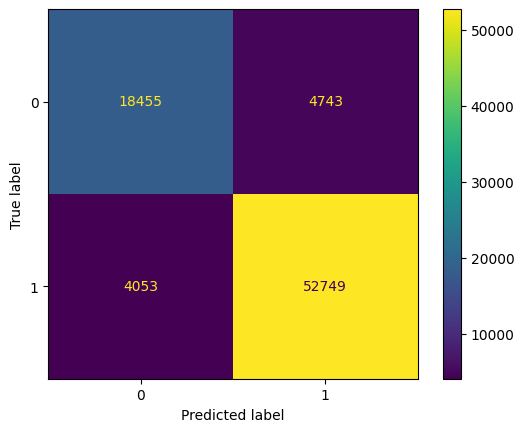

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     23198
           1       0.92      0.93      0.92     56802

    accuracy                           0.89     80000
   macro avg       0.87      0.86      0.87     80000
weighted avg       0.89      0.89      0.89     80000

AuC: 0.8620947989154826

Métricas de avaliação de teste:


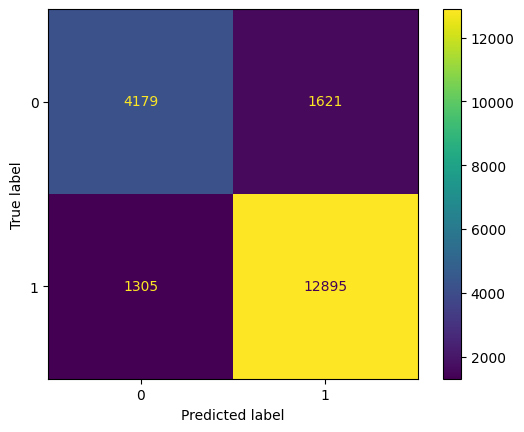

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      5800
           1       0.89      0.91      0.90     14200

    accuracy                           0.85     20000
   macro avg       0.83      0.81      0.82     20000
weighted avg       0.85      0.85      0.85     20000

AuC: 0.8143079164643031


In [26]:
#treinando o modelo SVM
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_preprocessed, y_train)

#avaliação do modelo com as métricas de classificação
metricas_classificacao(xgb_model, X_train_preprocessed, X_test_preprocessed, y_train, y_test)

In [27]:
#testando os hiperparâmetros
param_grid_xgb = {
    'eta': np.logspace(-2, 2, 5).tolist(),
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 3, 5]
}

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_xgb = GridSearchCV(
    estimator = XGBClassifier(random_state = 42),
    param_grid = param_grid_xgb,
    scoring = 'roc_auc',
    cv = splitter
)

Melhores hiperparâmetros: {'eta': 0.1, 'max_depth': 10, 'min_child_weight': 1}

Métricas de avaliação de treino:


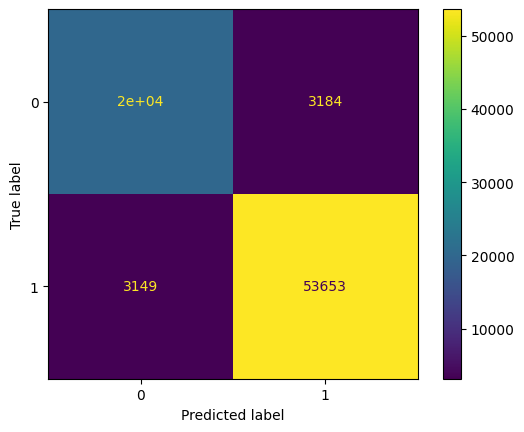

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     23198
           1       0.94      0.94      0.94     56802

    accuracy                           0.92     80000
   macro avg       0.90      0.90      0.90     80000
weighted avg       0.92      0.92      0.92     80000

AuC: 0.9036542998600412

Métricas de avaliação de teste:


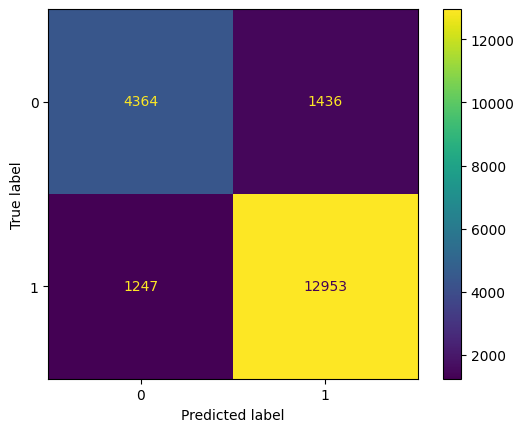

              precision    recall  f1-score   support

           0       0.78      0.75      0.76      5800
           1       0.90      0.91      0.91     14200

    accuracy                           0.87     20000
   macro avg       0.84      0.83      0.84     20000
weighted avg       0.86      0.87      0.87     20000

AuC: 0.8322984458474988


In [28]:
#treinamento do modelo
grid_xgb.fit(X_train_preprocessed, y_train)

#definição do melhor hiperparâmetro
best_params = grid_xgb.best_params_
best_model = grid_xgb.best_estimator_
svm_model.fit(X_train_preprocessed, y_train)
print('Melhores hiperparâmetros:', best_params)

#avaliação do modelo com os best params
metricas_classificacao(best_model, X_train_preprocessed, X_test_preprocessed, y_train, y_test)

Considerações Finais